<a href="https://colab.research.google.com/github/Ashish-Abraham/LLM-Boilerplate/blob/main/Qdrant/QdrantHybridSearchEcommerce.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hybrid Search Engine for E-Commerce using Qdrant

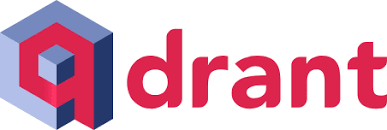

Download the csv from https://github.com/luminati-io/eCommerce-dataset-samples/blob/main/amazon-products.csv and upload in files.

In [ ]:

!pip install -q qdrant-client fastembed


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 377.2/377.2 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.5/108.5 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.6/61.6 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.4/17.4 MB 73.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 324.8/324.8 kB 18.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 4.8 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
from typing import List, Dict, Any, Optional
from collections import defaultdict
import re
import json

from qdrant_client import QdrantClient, models
from qdrant_client.models import Distance, VectorParams, PointStruct
from fastembed import TextEmbedding, SparseTextEmbedding

In [ ]:
# Initialize clients
print("Initializing Qdrant client and embedding models...")
client = QdrantClient(":memory:")  # Use in-memory for demo; switch to URL for production

# Dense embeddings (semantic search)
dense_model = TextEmbedding(model_name="BAAI/bge-small-en-v1.5")  # 384 dimensions, fast
dense_dim = 384

# Sparse embeddings (keyword/BM25-like search)
sparse_model = SparseTextEmbedding(model_name="Qdrant/bm25")

print("✓ Setup complete!")

Initializing Qdrant client and embedding models...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

special_tokens_map.json:   0%|          | 0.00/695 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/706 [00:00<?, ?B/s]

model_optimized.onnx:   0%|          | 0.00/66.5M [00:00<?, ?B/s]

Fetching 18 files:   0%|          | 0/18 [00:00<?, ?it/s]

danish.txt:   0%|          | 0.00/424 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

arabic.txt: 0.00B [00:00, ?B/s]

dutch.txt:   0%|          | 0.00/453 [00:00<?, ?B/s]

german.txt: 0.00B [00:00, ?B/s]

english.txt:   0%|          | 0.00/936 [00:00<?, ?B/s]

french.txt:   0%|          | 0.00/813 [00:00<?, ?B/s]

finnish.txt: 0.00B [00:00, ?B/s]

greek.txt: 0.00B [00:00, ?B/s]

italian.txt: 0.00B [00:00, ?B/s]

hungarian.txt: 0.00B [00:00, ?B/s]

norwegian.txt:   0%|          | 0.00/851 [00:00<?, ?B/s]

russian.txt: 0.00B [00:00, ?B/s]

romanian.txt: 0.00B [00:00, ?B/s]

spanish.txt: 0.00B [00:00, ?B/s]

swedish.txt:   0%|          | 0.00/559 [00:00<?, ?B/s]

portuguese.txt: 0.00B [00:00, ?B/s]

turkish.txt:   0%|          | 0.00/260 [00:00<?, ?B/s]

✓ Setup complete!


## DATA CLEANING & PREPROCESSING

In [ ]:
def clean_dataset(df: pd.DataFrame) -> pd.DataFrame:
    """Extract & clean required fields"""
    print("\n🔧 Cleaning dataset...")

    required_cols = ['asin', 'title', 'brand', 'description', 'categories',
                     'final_price', 'availability', 'rating', 'reviews_count']
    df_clean = df[required_cols].copy()

    # Clean text fields
    df_clean['asin'] = df_clean['asin'].fillna('').astype(str).str.strip()
    df_clean['title'] = df_clean['title'].fillna('').astype(str).str.strip()
    df_clean = df_clean[df_clean['title'] != '']
    df_clean['brand'] = df_clean['brand'].fillna('Unknown').astype(str).str.strip()
    df_clean['description'] = df_clean['description'].fillna('').astype(str).str.strip()

    # Parse categories from string
    def parse_categories(cat_str):
        try:
            if pd.isna(cat_str) or cat_str == '':
                return []
            cat_str = str(cat_str).strip('[]"')
            cats = [c.strip(' "\'') for c in cat_str.split(',')]
            return [c for c in cats if c]
        except:
            return []

    df_clean['categories'] = df_clean['categories'].apply(parse_categories)

    # Parse price
    def parse_price(price_str):
        try:
            if pd.isna(price_str):
                return 0.0
            return float(str(price_str).strip('"').replace(',', ''))
        except:
            return 0.0

    df_clean['final_price'] = df_clean['final_price'].apply(parse_price)

    # Stock status detection
    def get_stock_status(avail_str):
        avail_lower = str(avail_str).lower()
        if 'in stock' in avail_lower:
            return 'in_stock'
        elif 'only' in avail_lower or 'left' in avail_lower:
            return 'low_stock'
        return 'out_of_stock'

    df_clean['availability'] = df_clean['availability'].fillna('Out of Stock').astype(str)
    df_clean['stock_status'] = df_clean['availability'].apply(get_stock_status)

    # Numeric fields
    df_clean['rating'] = pd.to_numeric(df_clean['rating'], errors='coerce').fillna(0.0)
    df_clean['reviews_count'] = pd.to_numeric(df_clean['reviews_count'], errors='coerce').fillna(0).astype(int)

    df_clean = df_clean.drop_duplicates(subset='asin', keep='first')

    print(f"✓ Cleaned {len(df_clean)} products")
    print(f"  Brands: {df_clean['brand'].nunique()}, Avg price: ${df_clean['final_price'].mean():.2f}")
    print(f"  Stock: {(df_clean['stock_status']=='in_stock').sum()} in stock, {(df_clean['stock_status']=='low_stock').sum()} low stock")

    return df_clean.reset_index(drop=True)

In [ ]:
def create_collection(collection_name: str = "ecommerce_products"):
    """Create collection with dense+sparse vectors & quantization"""
    print(f"\n📦 Creating collection: {collection_name}")

    try:
        client.delete_collection(collection_name)
    except:
        pass

    client.create_collection(
        collection_name=collection_name,
        vectors_config={
            "dense": VectorParams(
                size=dense_dim,
                distance=Distance.COSINE,
                quantization_config=models.ScalarQuantization(
                    scalar=models.ScalarQuantizationConfig(
                        type=models.ScalarType.INT8,
                        quantile=0.99,
                        always_ram=True
                    )
                ),
                hnsw_config=models.HnswConfigDiff(
                    m=16,
                    ef_construct=100,
                    full_scan_threshold=10000
                )
            )
        },
        sparse_vectors_config={
            "sparse": models.SparseVectorParams()
        },
        optimizers_config=models.OptimizersConfigDiff(
            indexing_threshold=10000,
            memmap_threshold=20000
        )
    )

    print(f"✓ Collection created (dense: {dense_dim}-dim + sparse, INT8 quantized)")
    return collection_name

## PAYLOAD INDEXING (Full-text, ASCII folding, Multilingual)

In [ ]:
def create_payload_indexes(collection_name: str):
    """Full-text indexes with ASCII folding & multilingual tokenization"""
    print(f"\n🔍 Creating payload indexes...")

    # Title: multilingual + ASCII folding
    client.create_payload_index(
        collection_name=collection_name,
        field_name="title",
        field_schema=models.TextIndexParams(
            type=models.TextIndexType.TEXT,
            tokenizer=models.TokenizerType.MULTILINGUAL,
            min_token_len=2,
            max_token_len=30,
            lowercase=True,
            ascii_folding=True
        )
    )

    # Description: multilingual + ASCII folding
    client.create_payload_index(
        collection_name=collection_name,
        field_name="description",
        field_schema=models.TextIndexParams(
            type=models.TextIndexType.TEXT,
            tokenizer=models.TokenizerType.MULTILINGUAL,
            min_token_len=2,
            max_token_len=20,
            lowercase=True,
            ascii_folding=True
        )
    )

    # Keyword indexes
    for field in ['brand', 'categories', 'stock_status']:
        client.create_payload_index(
            collection_name=collection_name,
            field_name=field,
            field_schema=models.KeywordIndexParams(
                type=models.KeywordIndexType.KEYWORD
            )
        )

    # Numeric indexes
    client.create_payload_index(
        collection_name=collection_name,
        field_name="final_price",
        field_schema=models.IntegerIndexParams(
            type=models.IntegerIndexType.INTEGER,
            lookup=True,
            range=True
        )
    )

    client.create_payload_index(
        collection_name=collection_name,
        field_name="rating",
        field_schema=models.FloatIndexParams(
            type=models.FloatIndexType.FLOAT
        )
    )

    print("✓ Created 7 indexes: title, description, brand, categories, stock, price, rating")

## DATA INGESTION WITH BATCH PROCESSING

In [ ]:
def generate_embeddings_batch(texts: List[str], batch_size: int = 32):
    """Generate dense embeddings in batches"""
    embeddings = []
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        embeddings.extend(list(dense_model.embed(batch)))
    return embeddings

def generate_sparse_embeddings_batch(texts: List[str], batch_size: int = 32):
    """Generate sparse embeddings in batches"""
    embeddings = []
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        embeddings.extend(list(sparse_model.embed(batch)))
    return embeddings

def ingest_data(df: pd.DataFrame, collection_name: str, batch_size: int = 50):
    """Ingest data with dense + sparse vectors"""
    print(f"\n⬆️  Ingesting {len(df)} products...")

    # Combine text (title weighted 2x)
    combined_texts = [
        f"{row['title']} {row['title']} {row['brand']} {row['description'][:500]}"
        for _, row in df.iterrows()
    ]

    print("  Generating embeddings...")
    dense_embeddings = generate_embeddings_batch(combined_texts)
    sparse_embeddings = generate_sparse_embeddings_batch(combined_texts)

    # Prepare points
    points = []
    for idx, row in df.iterrows():
        sparse_emb = sparse_embeddings[idx]
        sparse_vector = models.SparseVector(
            indices=sparse_emb.indices.tolist(),
            values=sparse_emb.values.tolist()
        )

        point = PointStruct(
            id=idx,
            vector={
                "dense": dense_embeddings[idx].tolist(),
                "sparse": sparse_vector
            },
            payload={
                "asin": row['asin'],
                "title": row['title'],
                "brand": row['brand'],
                "description": row['description'][:1000],
                "categories": row['categories'],
                "final_price": float(row['final_price']),
                "availability": row['availability'],
                "stock_status": row['stock_status'],
                "rating": float(row['rating']),
                "reviews_count": int(row['reviews_count'])
            }
        )
        points.append(point)

    # Upload in batches
    for i in range(0, len(points), batch_size):
        batch = points[i:i+batch_size]
        client.upsert(collection_name=collection_name, points=batch)

    print(f"✓ Ingested {len(points)} products")

## Search

In [ ]:
def search_simple(query: str, collection_name: str = "ecommerce_products", limit: int = 10):
    """Simple semantic search (dense only)"""
    query_embedding = list(dense_model.embed([query]))[0]
    results = client.query_points(
        collection_name=collection_name,
        query=query_embedding.tolist(),
        using="dense",
        limit=limit,
        with_payload=True
    )
    return [{"score": r.score, **r.payload} for r in results.points]

def search_hybrid(query: str, collection_name: str = "ecommerce_products", limit: int = 10):
    """Hybrid: dense (semantic) + sparse (keyword) with RRF fusion"""
    dense_emb = list(dense_model.embed([query]))[0]
    sparse_emb = list(sparse_model.embed([query]))[0]

    sparse_vector = models.SparseVector(
        indices=sparse_emb.indices.tolist(),
        values=sparse_emb.values.tolist()
    )

    results = client.query_points(
        collection_name=collection_name,
        prefetch=[
            models.Prefetch(query=dense_emb.tolist(), using="dense", limit=limit*2),
            models.Prefetch(query=sparse_vector, using="sparse", limit=limit*2)
        ],
        query=models.FusionQuery(fusion=models.Fusion.RRF),
        with_payload=True,
        limit=limit
    )
    return [{"score": r.score, **r.payload} for r in results.points]

def search_with_boosting(query: str, collection_name: str = "ecommerce_products",
                        boost_brand: Optional[str] = None, limit: int = 10):
    """
    Score boosting with FormulaQuery:
    - +35% for brand match
    - +25% for low stock items
    """
    query_embedding = list(dense_model.embed([query]))[0]

    # Auto-detect brand
    if not boost_brand:
        query_lower = query.lower()
        brands = ['nike', 'adidas', 'saucony', 'puma', 'reebok']
        for b in brands:
            if b in query_lower:
                boost_brand = b.title()
                break

    formula_parts = ["$score"]

    if boost_brand:
        formula_parts.append(
            models.MultExpression(mult=[
                0.35,
                models.FieldCondition(key="brand", match=models.MatchValue(value=boost_brand))
            ])
        )

    formula_parts.append(
        models.MultExpression(mult=[
            0.25,
            models.FieldCondition(key="stock_status", match=models.MatchValue(value="low_stock"))
        ])
    )

    results = client.query_points(
        collection_name=collection_name,
        prefetch=models.Prefetch(query=query_embedding.tolist(), using="dense", limit=50),
        query=models.FormulaQuery(formula=models.SumExpression(sum=formula_parts)),
        with_payload=True,
        limit=limit
    )
    return [{"score": r.score, **r.payload} for r in results.points]

def search_with_acorn(query: str, collection_name: str = "ecommerce_products",
                     target_brands: Optional[List[str]] = None,
                     min_rating: float = 4.0,
                     max_price: Optional[float] = None,
                     prefer_low_stock: bool = True,
                     limit: int = 10):
    """
    ACORN search for complex filters:
    - MUST: rating ≥ threshold, not out of stock
    - SHOULD: target brands, price range, low stock
    """
    must = [
        models.FieldCondition(key="rating", range=models.Range(gte=min_rating))
    ]

    must_not = [
        models.FieldCondition(key="stock_status", match=models.MatchValue(value="out_of_stock"))
    ]

    should = []
    if target_brands:
        should.append(models.FieldCondition(key="brand", match=models.MatchAny(any=target_brands)))
    if max_price:
        should.append(models.FieldCondition(key="final_price", range=models.Range(lte=max_price)))
    if prefer_low_stock:
        should.append(models.FieldCondition(key="stock_status", match=models.MatchValue(value="low_stock")))

    query_embedding = list(dense_model.embed([query]))[0]

    results = client.query_points(
        collection_name=collection_name,
        query=query_embedding.tolist(),
        using="dense",
        query_filter=models.Filter(must=must, should=should, must_not=must_not),
        search_params=models.SearchParams(hnsw_ef=128, acorn=models.AcornSearchParams(
            enable=True,
            max_selectivity=0.4,
        )),
        limit=limit,
        with_payload=True
    )
    return [{"score": r.score, **r.payload} for r in results.points]

def search_full_text(query: str, collection_name: str = "ecommerce_products",
                    match_any: bool = False, limit: int = 10):
    """Full-text search on title/description with ASCII folding"""
    match_condition = (
        models.MatchText(text=query) if not match_any
        else models.MatchTextAny(text_any=query)
    )

    results = client.query_points(
        collection_name=collection_name,
        query_filter=models.Filter(should=[
            models.FieldCondition(key="title", match=match_condition),
            models.FieldCondition(key="description", match=match_condition)
        ]),
        limit=limit,
        with_payload=True
    )
    return [{"score": r.score, **r.payload} for r in results.points]

In [ ]:
def display_results(results: List[Dict], query: str, top_n: int = 5):
    """Pretty print results"""
    print(f"\n{'='*80}")
    print(f"Query: '{query}'")
    print(f"{'='*80}")

    for i, r in enumerate(results[:top_n], 1):
        print(f"\n[{i}] Score: {r.get('score', 0):.4f}")
        print(f"    {r['title'][:70]}")
        print(f"    {r['brand']} | ${r['final_price']:.2f} | {r['rating']}⭐ ({r['reviews_count']}) | {r['stock_status']}")

In [ ]:
# print("\n" + "="*80)
# print("QDRANT E-COMMERCE SEARCH ENGINE")
# print("="*80)

# # LOAD YOUR DATASET HERE
# df_raw = pd.read_csv('/content/amazon-products.csv')

# # Pipeline
# df_clean = clean_dataset(df_raw)
# collection_name = create_collection()
# create_payload_indexes(collection_name)
# ingest_data(df_clean, collection_name)

# print("\n🎉 Setup complete! Running demo searches...\n")

# # DEMO SEARCHES
# print("\n📍 1. Simple Semantic Search")
# results = search_simple("comfortable lightweight running shoes", limit=5)
# display_results(results, "comfortable lightweight running shoes")

# print("\n\n📍 2. Hybrid Search (Dense + Sparse)")
# results = search_hybrid("saucony kinvara", limit=5)
# display_results(results, "saucony kinvara")

# print("\n\n📍 3. Score Boosting (Brand + Low Stock)")
# results = search_with_boosting("running shoes", boost_brand="Saucony", limit=5)
# display_results(results, "running shoes [boosted: Saucony brand + low stock]")

# print("\n\n📍 4. ACORN Complex Filters")
# results = search_with_acorn(
#     "athletic shoes",
#     target_brands=["Saucony", "Nike"],
#     min_rating=4.0,
#     max_price=100,
#     prefer_low_stock=True,
#     limit=5
# )
# display_results(results, "athletic shoes [ACORN: brands, rating\u22654, price\u2264$100, prefer low stock]")

# print("\n\n📍 5. Full-Text Search")
# results = search_full_text("lightweight speed", match_any=True, limit=5)
# display_results(results, "lightweight speed [full-text with ASCII folding]")

# print("\n\n" + "="*80)
# print("SYSTEM DESIGN SUMMARY")
# print("="*80)
# print("""
# ✓ Dense Vectors: 384-dim FastEmbed (BAAI/bge-small-en-v1.5) for semantic search
# ✓ Sparse Vectors: BM25 embeddings for keyword matching
# ✓ Quantization: INT8 scalar quantization (~4x memory reduction)
# ✓ Full-Text Indexing: Multilingual tokenization + ASCII folding (café→cafe)
# ✓ ACORN: Optimizes complex MUST/SHOULD/MUST_NOT filter combinations
# ✓ Score Boosting: FormulaQuery for brand match (+35%) & low stock (+25%)
# ✓ HNSW: Optimized approximate nearest neighbor search
# ✓ Batch Processing: Efficient embedding generation and upload

# WHEN TO USE WHAT:
# - Simple queries: search_simple() - fastest, pure semantic
# - Brand/product names: search_hybrid() - combines semantic + keyword
# - Promotional ranking: search_with_boosting() - rerank by business logic
# - Complex filters: search_with_acorn() - optimizes multi-constraint queries
# - Exact phrases: search_full_text() - traditional text search
# """)

In [ ]:
# df_raw.columns

## UI

In [ ]:
!pip install streamlit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.0/9.0 MB 17.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 28.8 MB/s eta 0:00:00


In [ ]:
"""
COMPLETE E-COMMERCE SEARCH SYSTEM
==================================

This file contains:
1. setup_database.py - Run this FIRST to ingest data
2. app.py - Run this SECOND for the Streamlit UI

INSTRUCTIONS:
1. Save your dataset as 'amazon_products.csv' in the same folder
2. Run: python setup_database.py
3. Run: streamlit run app.py

Required packages:
pip install qdrant-client fastembed pandas numpy streamlit
"""

# ============================================================================
# FILE 1: setup_database.py
# ============================================================================

SETUP_DATABASE_CODE = '''
"""
setup_database.py
Run this FIRST to ingest data into Qdrant
Usage: python setup_database.py
"""

import pandas as pd
import numpy as np
from typing import List
from qdrant_client import QdrantClient, models
from qdrant_client.models import Distance, VectorParams, PointStruct
from fastembed import TextEmbedding, SparseTextEmbedding

print("="*80)
print("QDRANT DATABASE SETUP")
print("="*80)

# Initialize
print("\\nInitializing models...")
client = QdrantClient(path="./qdrant_data")  # Persistent storage
dense_model = TextEmbedding(model_name="BAAI/bge-small-en-v1.5")
sparse_model = SparseTextEmbedding(model_name="Qdrant/bm25")
dense_dim = 384
collection_name = "ecommerce_products"

# Clean dataset
def clean_dataset(df: pd.DataFrame) -> pd.DataFrame:
    print("\\n🔧 Cleaning dataset...")

    required_cols = ['asin', 'title', 'brand', 'description', 'categories',
                     'final_price', 'availability', 'rating', 'reviews_count']
    df_clean = df[required_cols].copy()

    df_clean['asin'] = df_clean['asin'].fillna('').astype(str).str.strip()
    df_clean['title'] = df_clean['title'].fillna('').astype(str).str.strip()
    df_clean = df_clean[df_clean['title'] != '']
    df_clean['brand'] = df_clean['brand'].fillna('Unknown').astype(str).str.strip()
    df_clean['description'] = df_clean['description'].fillna('').astype(str).str.strip()

    def parse_categories(cat_str):
        try:
            if pd.isna(cat_str) or cat_str == '':
                return []
            cat_str = str(cat_str).strip('[]"')
            cats = [c.strip(' "\\'') for c in cat_str.split(',')]
            return [c for c in cats if c]
        except:
            return []

    df_clean['categories'] = df_clean['categories'].apply(parse_categories)

    def parse_price(price_str):
        try:
            if pd.isna(price_str):
                return 0.0
            return float(str(price_str).strip('"').replace(',', ''))
        except:
            return 0.0

    df_clean['final_price'] = df_clean['final_price'].apply(parse_price)

    def get_stock_status(avail_str):
        avail_lower = str(avail_str).lower()
        if 'in stock' in avail_lower:
            return 'in_stock'
        elif 'only' in avail_lower or 'left' in avail_lower:
            return 'low_stock'
        return 'out_of_stock'

    df_clean['availability'] = df_clean['availability'].fillna('Out of Stock').astype(str)
    df_clean['stock_status'] = df_clean['availability'].apply(get_stock_status)

    df_clean['rating'] = pd.to_numeric(df_clean['rating'], errors='coerce').fillna(0.0)
    df_clean['reviews_count'] = pd.to_numeric(df_clean['reviews_count'], errors='coerce').fillna(0).astype(int)

    df_clean = df_clean.drop_duplicates(subset='asin', keep='first')

    print(f"✓ Cleaned {len(df_clean)} products")
    return df_clean.reset_index(drop=True)

# Create collection
def create_collection():
    print(f"\\n📦 Creating collection: {collection_name}")

    try:
        client.delete_collection(collection_name)
    except:
        pass

    client.create_collection(
        collection_name=collection_name,
        vectors_config={
            "dense": VectorParams(
                size=dense_dim,
                distance=Distance.COSINE,
                quantization_config=models.ScalarQuantization(
                    scalar=models.ScalarQuantizationConfig(
                        type=models.ScalarType.INT8,
                        quantile=0.99,
                        always_ram=True
                    )
                ),
                hnsw_config=models.HnswConfigDiff(
                    m=16,
                    ef_construct=100,
                    full_scan_threshold=10000
                )
            )
        },
        sparse_vectors_config={
            "sparse": models.SparseVectorParams()
        }
    )
    print("✓ Collection created")

# Create indexes
def create_indexes():
    print(f"\\n🔍 Creating indexes...")

    # Title & description with multilingual + ASCII folding
    for field in ['title', 'description']:
        client.create_payload_index(
            collection_name=collection_name,
            field_name=field,
            field_schema=models.TextIndexParams(
                type=models.TextIndexType.TEXT,
                tokenizer=models.TokenizerType.MULTILINGUAL,
                min_token_len=2,
                max_token_len=30 if field == 'title' else 20,
                lowercase=True,
                ascii_folding=True
            )
        )

    # Keyword indexes
    for field in ['brand', 'categories', 'stock_status']:
        client.create_payload_index(
            collection_name=collection_name,
            field_name=field,
            field_schema=models.KeywordIndexParams(
                type=models.KeywordIndexType.KEYWORD
            )
        )

    # Numeric indexes
    client.create_payload_index(
        collection_name=collection_name,
        field_name="final_price",
        field_schema=models.IntegerIndexParams(
            type=models.IntegerIndexType.INTEGER,
            lookup=True,
            range=True
        )
    )

    client.create_payload_index(
        collection_name=collection_name,
        field_name="rating",
        field_schema=models.FloatIndexParams(
            type=models.FloatIndexType.FLOAT
        )
    )

    print("✓ Created 7 indexes")

# Ingest data
def ingest_data(df: pd.DataFrame, batch_size: int = 50):
    print(f"\\n⬆️  Ingesting {len(df)} products...")

    combined_texts = [
        f"{row['title']} {row['title']} {row['brand']} {row['description'][:500]}"
        for _, row in df.iterrows()
    ]

    print("  Generating embeddings...")
    dense_embeddings = []
    for i in range(0, len(combined_texts), 32):
        batch = combined_texts[i:i+32]
        dense_embeddings.extend(list(dense_model.embed(batch)))

    sparse_embeddings = []
    for i in range(0, len(combined_texts), 32):
        batch = combined_texts[i:i+32]
        sparse_embeddings.extend(list(sparse_model.embed(batch)))

    print("  Building points...")
    points = []
    for idx, row in df.iterrows():
        sparse_emb = sparse_embeddings[idx]
        sparse_vector = models.SparseVector(
            indices=sparse_emb.indices.tolist(),
            values=sparse_emb.values.tolist()
        )

        point = PointStruct(
            id=idx,
            vector={
                "dense": dense_embeddings[idx].tolist(),
                "sparse": sparse_vector
            },
            payload={
                "asin": row['asin'],
                "title": row['title'],
                "brand": row['brand'],
                "description": row['description'][:1000],
                "categories": row['categories'],
                "final_price": float(row['final_price']),
                "availability": row['availability'],
                "stock_status": row['stock_status'],
                "rating": float(row['rating']),
                "reviews_count": int(row['reviews_count'])
            }
        )
        points.append(point)

    print("  Uploading to Qdrant...")
    for i in range(0, len(points), batch_size):
        batch = points[i:i+batch_size]
        client.upsert(collection_name=collection_name, points=batch)
        if (i + batch_size) % 100 == 0:
            print(f"    Uploaded {min(i+batch_size, len(points))}/{len(points)}")

    print(f"✓ Ingested {len(points)} products")

# Main execution
if __name__ == "__main__":
    try:
        # Load data
        print("\\n📂 Loading dataset...")
        df = pd.read_csv('/content/amazon-products.csv')
        print(f"✓ Loaded {len(df)} rows")

        # Clean
        df_clean = clean_dataset(df)

        # Setup
        create_collection()
        create_indexes()
        ingest_data(df_clean)

        print("\\n" + "="*80)
        print("✅ DATABASE SETUP COMPLETE!")
        print("="*80)
        print("\\nYou can now run: streamlit run app.py")

    except FileNotFoundError:
        print("\\n❌ ERROR: amazon_products.csv not found!")
        print("Please save your dataset as 'amazon_products.csv' in this folder.")
    except Exception as e:
        print(f"\\n❌ ERROR: {e}")
        import traceback
        traceback.print_exc()
'''

# ============================================================================
# FILE 2: app.py
# ============================================================================

APP_CODE = '''
"""
app.py
E-commerce Search UI with Streamlit
Usage: streamlit run app.py
"""

import streamlit as st
import pandas as pd
from typing import List, Dict, Optional
from qdrant_client import QdrantClient, models
from fastembed import TextEmbedding, SparseTextEmbedding
import time

# Page config
st.set_page_config(
    page_title="ShopSmart - AI Search",
    page_icon="🛍️",
    layout="wide",
    initial_sidebar_state="expanded"
)

# CSS
st.markdown("""
<style>
    .main { background-color: #f8f9fa; }
    .product-card {
        background: white;
        border-radius: 12px;
        padding: 20px;
        margin: 10px 0;
        box-shadow: 0 2px 8px rgba(0,0,0,0.1);
        transition: transform 0.2s, box-shadow 0.2s;
    }
    .product-card:hover {
        transform: translateY(-4px);
        box-shadow: 0 4px 16px rgba(0,0,0,0.15);
    }
    .product-title {
        font-size: 18px;
        font-weight: 600;
        color: #1a1a1a;
        margin-bottom: 8px;
        line-height: 1.4;
    }
    .product-brand {
        color: #0066cc;
        font-weight: 500;
        font-size: 14px;
    }
    .product-price {
        font-size: 24px;
        font-weight: 700;
        color: #B12704;
        margin: 10px 0;
    }
    .stock-badge {
        display: inline-block;
        padding: 4px 12px;
        border-radius: 12px;
        font-size: 12px;
        font-weight: 600;
        margin-top: 8px;
    }
    .stock-in { background-color: #d4edda; color: #155724; }
    .stock-low { background-color: #fff3cd; color: #856404; }
    .stock-out { background-color: #f8d7da; color: #721c24; }
    .search-mode-badge {
        background: linear-gradient(135deg, #667eea 0%, #764ba2 100%);
        color: white;
        padding: 8px 16px;
        border-radius: 20px;
        font-size: 12px;
        font-weight: 600;
        display: inline-block;
        margin: 10px 0;
    }
</style>
""", unsafe_allow_html=True)

# Initialize session state
if 'initialized' not in st.session_state:
    st.session_state.initialized = False
    st.session_state.search_history = []
    st.session_state.total_products = 0

@st.cache_resource
def initialize_system():
    """Initialize Qdrant and models"""
    try:
        client = QdrantClient(path="./qdrant_data")
        dense_model = TextEmbedding(model_name="BAAI/bge-small-en-v1.5")
        sparse_model = SparseTextEmbedding(model_name="Qdrant/bm25")
        return client, dense_model, sparse_model
    except Exception as e:
        st.error(f"Failed to initialize: {e}")
        st.stop()

def load_system():
    """Load system once"""
    if not st.session_state.initialized:
        with st.spinner("🚀 Loading AI search engine..."):
            client, dense_model, sparse_model = initialize_system()
            st.session_state.client = client
            st.session_state.dense_model = dense_model
            st.session_state.sparse_model = sparse_model

            try:
                info = client.get_collection("ecommerce_products")
                st.session_state.total_products = info.points_count
                st.session_state.initialized = True
            except:
                st.error("⚠️ Database not found! Run: python setup_database.py")
                st.stop()

# Search functions
def search_simple(query: str, limit: int = 10):
    query_embedding = list(st.session_state.dense_model.embed([query]))[0]
    results = st.session_state.client.query_points(
        collection_name="ecommerce_products",
        query=query_embedding.tolist(),
        using="dense",
        limit=limit,
        with_payload=True
    )
    return [{"score": r.score, **r.payload} for r in results.points]

def search_hybrid(query: str, limit: int = 10):
    dense_emb = list(st.session_state.dense_model.embed([query]))[0]
    sparse_emb = list(st.session_state.sparse_model.embed([query]))[0]

    sparse_vector = models.SparseVector(
        indices=sparse_emb.indices.tolist(),
        values=sparse_emb.values.tolist()
    )

    results = st.session_state.client.query_points(
        collection_name="ecommerce_products",
        prefetch=[
            models.Prefetch(query=dense_emb.tolist(), using="dense", limit=limit*2),
            models.Prefetch(query=sparse_vector, using="sparse", limit=limit*2)
        ],
        query=models.FusionQuery(fusion=models.Fusion.RRF),
        with_payload=True,
        limit=limit
    )
    return [{"score": r.score, **r.payload} for r in results.points]

def search_with_boosting(query: str, boost_brand: Optional[str] = None, limit: int = 10):
    query_embedding = list(st.session_state.dense_model.embed([query]))[0]

    if not boost_brand:
        query_lower = query.lower()
        brands = ['nike', 'adidas', 'saucony', 'puma', 'reebok', 'new balance', 'asics']
        for b in brands:
            if b in query_lower:
                boost_brand = b.title()
                break

    formula_parts = ["$score"]

    if boost_brand:
        formula_parts.append(
            models.MultExpression(mult=[
                0.35,
                models.FieldCondition(key="brand", match=models.MatchValue(value=boost_brand))
            ])
        )

    formula_parts.append(
        models.MultExpression(mult=[
            0.25,
            models.FieldCondition(key="stock_status", match=models.MatchValue(value="low_stock"))
        ])
    )

    results = st.session_state.client.query_points(
        collection_name="ecommerce_products",
        prefetch=models.Prefetch(query=query_embedding.tolist(), using="dense", limit=50),
        query=models.FormulaQuery(formula=models.SumExpression(sum=formula_parts)),
        with_payload=True,
        limit=limit
    )
    return [{"score": r.score, **r.payload} for r in results.points]

def search_with_filters(query: str, brands=None, min_price=None, max_price=None,
                       min_rating=None, categories=None, stock_filter=None,
                       limit=10, use_acorn=False):
    must, should, must_not = [], [], []

    if min_rating:
        must.append(models.FieldCondition(key="rating", range=models.Range(gte=min_rating)))

    if brands:
        condition = models.FieldCondition(key="brand", match=models.MatchAny(any=brands))
        (should if use_acorn else must).append(condition)

    if min_price is not None or max_price is not None:
        range_dict = {}
        if min_price: range_dict['gte'] = min_price
        if max_price: range_dict['lte'] = max_price
        condition = models.FieldCondition(key="final_price", range=models.Range(**range_dict))
        (should if use_acorn else must).append(condition)

    if categories:
        must.append(models.FieldCondition(key="categories", match=models.MatchAny(any=categories)))

    if stock_filter == "exclude_out_of_stock":
        must_not.append(models.FieldCondition(key="stock_status", match=models.MatchValue(value="out_of_stock")))
    elif stock_filter == "in_stock_only":
        must.append(models.FieldCondition(key="stock_status", match=models.MatchValue(value="in_stock")))

    query_filter = models.Filter(
        must=must if must else None,
        should=should if should else None,
        must_not=must_not if must_not else None
    )

    query_embedding = list(st.session_state.dense_model.embed([query]))[0]

    search_params = None
    if use_acorn:
        search_params = models.SearchParams(
            hnsw_ef=128,
            acorn=models.AcornSearchParams(enable=True, max_selectivity=0.4)
        )

    results = st.session_state.client.query_points(
        collection_name="ecommerce_products",
        query=query_embedding.tolist(),
        using="dense",
        query_filter=query_filter,
        search_params=search_params,
        limit=limit,
        with_payload=True
    )
    return [{"score": r.score, **r.payload} for r in results.points]

def smart_search(query: str, filters: Dict, limit: int = 10):
    has_filters = any(filters.values())

    query_lower = query.lower()
    brands = ['nike', 'adidas', 'saucony', 'puma', 'reebok', 'new balance', 'asics']
    has_brand = any(b in query_lower for b in brands)

    filter_count = sum([bool(v) for v in filters.values()])

    if has_filters:
        use_acorn = filter_count >= 3
        mode = "🎯 ACORN Search" if use_acorn else "🔍 Filtered Search"
        results = search_with_filters(query, **filters, limit=limit, use_acorn=use_acorn)
    elif has_brand:
        mode = "🚀 Boosted Search"
        results = search_with_boosting(query, limit=limit)
    elif len(query.split()) <= 2:
        mode = "⚡ Hybrid Search"
        results = search_hybrid(query, limit=limit)
    else:
        mode = "🧠 Semantic Search"
        results = search_simple(query, limit=limit)

    return results, mode

# UI Components
def render_product_card(product: Dict):
    stock_status = product.get('stock_status', 'out_of_stock')
    stock_class = f"stock-{stock_status.replace('_', '-')}"
    stock_text = {
        'in_stock': '✓ In Stock',
        'low_stock': '⚠️ Low Stock',
        'out_of_stock': '✗ Out of Stock'
    }.get(stock_status, 'Unknown')

    rating = product.get('rating', 0)
    stars = "⭐" * int(rating) + "☆" * (5 - int(rating))

    st.markdown(f"""
    <div class="product-card">
        <div class="product-brand">{product.get('brand', 'Unknown')}</div>
        <div class="product-title">{product.get('title', 'No Title')[:100]}</div>
        <div class="product-price">${product.get('final_price', 0):.2f}</div>
        <div>{stars} {rating:.1f} ({product.get('reviews_count', 0)} reviews)</div>
        <div class="stock-badge {stock_class}">{stock_text}</div>
        <div style="margin-top: 12px; font-size: 12px; color: #666;">
            Score: {product.get('score', 0):.3f}
        </div>
    </div>
    """, unsafe_allow_html=True)

    with st.expander("📝 Details"):
        st.write(f"**ASIN:** {product.get('asin', 'N/A')}")
        st.write(f"**Description:** {product.get('description', 'N/A')[:300]}...")

def render_filters():
    st.sidebar.title("🔧 Filters")

    filters = {}

    brands = st.sidebar.multiselect(
        "Brand",
        ["Nike", "Adidas", "Saucony", "Puma", "Reebok", "New Balance", "Asics"]
    )
    filters['brands'] = brands if brands else None

    price_range = st.sidebar.slider("Price Range", 0, 500, (0, 500), 10)
    filters['min_price'] = price_range[0] if price_range[0] > 0 else None
    filters['max_price'] = price_range[1] if price_range[1] < 500 else None

    min_rating = st.sidebar.select_slider("Min Rating", [0, 1, 2, 3, 4, 4.5, 5], 0)
    filters['min_rating'] = min_rating if min_rating > 0 else None

    stock = st.sidebar.radio("Stock", ["All", "In Stock Only", "Exclude Out of Stock"])
    filters['stock_filter'] = {
        "All": None,
        "In Stock Only": "in_stock_only",
        "Exclude Out of Stock": "exclude_out_of_stock"
    }[stock]

    filters['categories'] = None
    filters['limit'] = 20

    if st.sidebar.button("🔄 Clear Filters"):
        st.rerun()

    return filters

# Main app
def main():
    load_system()

    col1, col2 = st.columns([3, 1])
    with col1:
        st.title("🛍️ ShopSmart")
        st.markdown("*AI-Powered Product Search*")
    with col2:
        st.metric("Products", f"{st.session_state.total_products:,}")

    query = st.text_input(
        "Search",
        placeholder="Try: comfortable running shoes, nike sneakers...",
        label_visibility="collapsed"
    )

    filters = render_filters()

    if query:
        with st.spinner("Searching..."):
            start = time.time()
            results, mode = smart_search(query, filters)
            elapsed = time.time() - start

        col1, col2, col3 = st.columns([2, 2, 1])
        with col1:
            st.markdown(f"<div class='search-mode-badge'>{mode}</div>", unsafe_allow_html=True)
        with col2:
            st.success(f"✓ {len(results)} results in {elapsed:.2f}s")
        with col3:
            sort = st.selectbox("Sort", ["Relevance", "Price ↑", "Price ↓", "Rating"], label_visibility="collapsed")

        if sort == "Price ↑":
            results = sorted(results, key=lambda x: x.get('final_price', 0))
        elif sort == "Price ↓":
            results = sorted(results, key=lambda x: x.get('final_price', 0), reverse=True)
        elif sort == "Rating":
            results = sorted(results, key=lambda x: x.get('rating', 0), reverse=True)

        if results:
            for i in range(0, len(results), 2):
                cols = st.columns(2)
                for j, col in enumerate(cols):
                    if i + j < len(results):
                        with col:
                            render_product_card(results[i + j])
        else:
            st.warning("No products found")
    else:
        st.info("👋 Start searching above!")

if __name__ == "__main__":
    main()
'''

# ============================================================================
# SAVE FILES
# ============================================================================

if __name__ == "__main__":
    print("Creating files...")

    with open('setup_database.py', 'w', encoding='utf-8') as f:
        f.write(SETUP_DATABASE_CODE)
    print("✓ Created setup_database.py")

    with open('app.py', 'w', encoding='utf-8') as f:
        f.write(APP_CODE)
    print("✓ Created app.py")

    print("\n" + "="*80)
    print("FILES CREATED SUCCESSFULLY!")
    print("="*80)
    print("\nNext steps:")
    print("1. Save your dataset as 'amazon_products.csv'")
    print("2. Run: python setup_database.py")
    print("3. Run: streamlit run app.py")
    print("="*80)

Creating files...
✓ Created setup_database.py
✓ Created app.py

FILES CREATED SUCCESSFULLY!

Next steps:
1. Save your dataset as 'amazon_products.csv'
2. Run: python setup_database.py
3. Run: streamlit run app.py


In [ ]:
!python3 /content/setup_database.py

QDRANT DATABASE SETUP

Initializing models...

📂 Loading dataset...
✓ Loaded 1000 rows

🔧 Cleaning dataset...
✓ Cleaned 1000 products

📦 Creating collection: ecommerce_products
✓ Collection created

🔍 Creating indexes...
/content/setup_database.py:123: UserWarning: Payload indexes have no effect in the local Qdrant. Please use server Qdrant if you need payload indexes.
  client.create_payload_index(
✓ Created 7 indexes

⬆️  Ingesting 1000 products...
  Generating embeddings...
  Building points...
  Uploading to Qdrant...
    Uploaded 100/1000
    Uploaded 200/1000
    Uploaded 300/1000
    Uploaded 400/1000
    Uploaded 500/1000
    Uploaded 600/1000
    Uploaded 700/1000
    Uploaded 800/1000
    Uploaded 900/1000
    Uploaded 1000/1000
✓ Ingested 1000 products

✅ DATABASE SETUP COMPLETE!

You can now run: streamlit run app.py
Exception ignored in: <function QdrantClient.__del__ at 0x7b6e513e9440>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/qdra

In [ ]:
!wget -q -O - ipv4.icanhazip.com

34.82.29.16


In [ ]:
!npm install localtunnel

⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸⠼⠴⠦⠧⠇⠏
added 22 packages in 2s
⠏
⠏3 packages are looking for funding
⠏  run `npm fund` for details
⠏

In [ ]:
"""
E-commerce Search Engine UI with Gradio
========================================
Professional e-commerce interface with:
- Smart search (auto-selects best search method)
- Advanced filters (brand, price, rating, stock)
- Product cards with details
- Sort options
- Search analytics

Installation:
pip install gradio qdrant-client fastembed pandas

Run:
python app.py
"""

import gradio as gr
import pandas as pd
from typing import List, Dict, Optional, Tuple
from qdrant_client import QdrantClient, models
from fastembed import TextEmbedding, SparseTextEmbedding
import time

# ============================================================================
# INITIALIZE SYSTEM
# ============================================================================

print("🚀 Initializing AI Search Engine...")
client = QdrantClient(path="./qdrant_data")
dense_model = TextEmbedding(model_name="BAAI/bge-small-en-v1.5")
sparse_model = SparseTextEmbedding(model_name="Qdrant/bm25")

# Get collection info
try:
    collection_info = client.get_collection("ecommerce_products")
    total_products = collection_info.points_count
    print(f"✓ Loaded {total_products} products from database")
except Exception as e:
    print(f"❌ Error: Database not found!")
    print(f"   Please run: python setup_database.py")
    exit(1)

# ============================================================================
# SEARCH FUNCTIONS
# ============================================================================

def search_simple(query: str, limit: int = 10):
    """Simple semantic search (dense only)"""
    query_embedding = list(dense_model.embed([query]))[0]
    results = client.query_points(
        collection_name="ecommerce_products",
        query=query_embedding.tolist(),
        using="dense",
        limit=limit,
        with_payload=True
    )
    return [{"score": r.score, **r.payload} for r in results.points]

def search_hybrid(query: str, limit: int = 10):
    """Hybrid: dense (semantic) + sparse (keyword) with RRF fusion"""
    dense_emb = list(dense_model.embed([query]))[0]
    sparse_emb = list(sparse_model.embed([query]))[0]

    sparse_vector = models.SparseVector(
        indices=sparse_emb.indices.tolist(),
        values=sparse_emb.values.tolist()
    )

    results = client.query_points(
        collection_name="ecommerce_products",
        prefetch=[
            models.Prefetch(query=dense_emb.tolist(), using="dense", limit=limit*2),
            models.Prefetch(query=sparse_vector, using="sparse", limit=limit*2)
        ],
        query=models.FusionQuery(fusion=models.Fusion.RRF),
        with_payload=True,
        limit=limit
    )
    return [{"score": r.score, **r.payload} for r in results.points]

def search_with_boosting(query: str, boost_brand: Optional[str] = None, limit: int = 10):
    """Score boosting with FormulaQuery"""
    query_embedding = list(dense_model.embed([query]))[0]

    # Auto-detect brand
    if not boost_brand:
        query_lower = query.lower()
        brands = ['nike', 'adidas', 'saucony', 'puma', 'reebok', 'new balance', 'asics']
        for b in brands:
            if b in query_lower:
                boost_brand = b.title()
                break

    formula_parts = ["$score"]

    if boost_brand:
        formula_parts.append(
            models.MultExpression(mult=[
                0.35,
                models.FieldCondition(key="brand", match=models.MatchValue(value=boost_brand))
            ])
        )

    formula_parts.append(
        models.MultExpression(mult=[
            0.25,
            models.FieldCondition(key="stock_status", match=models.MatchValue(value="low_stock"))
        ])
    )

    results = client.query_points(
        collection_name="ecommerce_products",
        prefetch=models.Prefetch(query=query_embedding.tolist(), using="dense", limit=50),
        query=models.FormulaQuery(formula=models.SumExpression(sum=formula_parts)),
        with_payload=True,
        limit=limit
    )
    return [{"score": r.score, **r.payload} for r in results.points]

def search_with_filters(
    query: str,
    brands=None,
    min_price=None,
    max_price=None,
    min_rating=None,
    categories=None,
    stock_filter=None,
    limit=10,
    use_acorn=False
):
    """Advanced search with filters (uses ACORN for complex queries)"""
    must, should, must_not = [], [], []

    if min_rating and min_rating > 0:
        must.append(models.FieldCondition(key="rating", range=models.Range(gte=min_rating)))

    if brands:
        condition = models.FieldCondition(key="brand", match=models.MatchAny(any=brands))
        (should if use_acorn else must).append(condition)

    if min_price is not None or max_price is not None:
        range_dict = {}
        if min_price and min_price > 0:
            range_dict['gte'] = min_price
        if max_price and max_price < 500:
            range_dict['lte'] = max_price
        if range_dict:
            condition = models.FieldCondition(key="final_price", range=models.Range(**range_dict))
            (should if use_acorn else must).append(condition)

    if categories:
        must.append(models.FieldCondition(key="categories", match=models.MatchAny(any=categories)))

    if stock_filter == "exclude_out_of_stock":
        must_not.append(models.FieldCondition(key="stock_status", match=models.MatchValue(value="out_of_stock")))
    elif stock_filter == "in_stock_only":
        must.append(models.FieldCondition(key="stock_status", match=models.MatchValue(value="in_stock")))

    # Only create filter if there are actual conditions
    query_filter = None
    if must or should or must_not:
        query_filter = models.Filter(
            must=must if must else None,
            should=should if should else None,
            must_not=must_not if must_not else None
        )

    query_embedding = list(dense_model.embed([query]))[0]

    search_params = None
    if use_acorn and query_filter:
        search_params = models.SearchParams(
            hnsw_ef=128,
            acorn=models.AcornSearchParams(enable=True, max_selectivity=0.4)
        )

    results = client.query_points(
        collection_name="ecommerce_products",
        query=query_embedding.tolist(),
        using="dense",
        query_filter=query_filter,
        search_params=search_params,
        limit=limit,
        with_payload=True
    )
    return [{"score": r.score, **r.payload} for r in results.points]

# ============================================================================
# SMART SEARCH
# ============================================================================

def smart_search(
    query: str,
    brands: List[str],
    price_min: float,
    price_max: float,
    min_rating: float,
    stock_filter: str,
    sort_by: str,
    limit: int = 20
) -> Tuple[str, str]:
    """
    Smart search that auto-selects best method
    Returns: (HTML output, search info)
    """

    # Handle empty or None query
    if not query or str(query).strip() == "":
        welcome_html = """
        <div style="text-align: center; padding: 60px 20px; background: white; border-radius: 12px; box-shadow: 0 2px 8px rgba(0,0,0,0.1);">
            <h2 style="color: #667eea; margin-bottom: 20px;">👋 Welcome to ShopSmart!</h2>
            <p style="font-size: 18px; color: #666; margin-bottom: 30px;">
                Enter a search query above to find products using AI-powered search.
            </p>
            <div style="background: #f8f9fa; padding: 20px; border-radius: 8px; max-width: 600px; margin: 0 auto;">
                <h3 style="color: #333; margin-bottom: 15px;">💡 Try searching for:</h3>
                <ul style="text-align: left; color: #666; line-height: 2;">
                    <li>comfortable running shoes</li>
                    <li>nike athletic wear</li>
                    <li>lightweight sneakers under $100</li>
                    <li>high-rated sports shoes</li>
                </ul>
            </div>
        </div>
        """
        return welcome_html, "Ready to search"

    query = str(query).strip()

    # Prepare filters
    filters = {
        'brands': brands if brands else None,
        'min_price': price_min if price_min > 0 else None,
        'max_price': price_max if price_max < 500 else None,
        'min_rating': min_rating if min_rating > 0 else None,
        'categories': None,
        'stock_filter': {
            "All Products": None,
            "In Stock Only": "in_stock_only",
            "Exclude Out of Stock": "exclude_out_of_stock"
        }.get(stock_filter),
        'limit': limit
    }

    # Determine search method
    has_filters = any([v for k, v in filters.items() if k != 'limit' and v is not None])
    query_lower = query.lower()
    brands_list = ['nike', 'adidas', 'saucony', 'puma', 'reebok', 'new balance', 'asics']
    has_brand = any(b in query_lower for b in brands_list)
    filter_count = sum([1 for k, v in filters.items() if v and k != 'limit'])

    # Execute search
    start_time = time.time()

    try:
        if has_filters:
            use_acorn = filter_count >= 3
            search_mode = "🎯 ACORN Search" if use_acorn else "🔍 Filtered Search"
            results = search_with_filters(query, **filters, use_acorn=use_acorn)
        elif has_brand:
            search_mode = "🚀 Boosted Search"
            results = search_with_boosting(query, limit=limit)
        elif len(query.split()) <= 2:
            search_mode = "⚡ Hybrid Search"
            results = search_hybrid(query, limit=limit)
        else:
            search_mode = "🧠 Semantic Search"
            results = search_simple(query, limit=limit)

        search_time = time.time() - start_time

        # Sort results
        if sort_by == "Price: Low to High":
            results = sorted(results, key=lambda x: x.get('final_price', 0))
        elif sort_by == "Price: High to Low":
            results = sorted(results, key=lambda x: x.get('final_price', 0), reverse=True)
        elif sort_by == "Rating: High to Low":
            results = sorted(results, key=lambda x: x.get('rating', 0), reverse=True)

    except Exception as e:
        error_html = f"""
        <div style="background: #f8d7da; color: #721c24; padding: 20px; border-radius: 8px; border-left: 4px solid #dc3545;">
            <h3>❌ Search Error</h3>
            <p>An error occurred while searching: {str(e)}</p>
        </div>
        """
        return error_html, f"Error: {str(e)}"

    # Generate HTML output
    if not results:
        html_output = """
        <div style="text-align: center; padding: 40px; background: white; border-radius: 12px; box-shadow: 0 2px 8px rgba(0,0,0,0.1);">
            <h3 style="color: #666;">😕 No products found</h3>
            <p style="color: #999;">Try adjusting your filters or search query.</p>
        </div>
        """
        search_info = f"{search_mode} • 0 results • {search_time:.2f}s"
        return html_output, search_info

    # Build HTML
    html_parts = []

    # Search info
    search_info = f"{search_mode} • {len(results)} results • {search_time:.2f}s"

    # Active filters
    active_filters = []
    if filters.get('brands'):
        active_filters.append(f"Brands: {', '.join(filters['brands'])}")
    if filters.get('min_price') or filters.get('max_price'):
        min_p = filters.get('min_price', 0)
        max_p = filters.get('max_price', 500)
        active_filters.append(f"Price: ${min_p:.0f}-${max_p:.0f}")
    if filters.get('min_rating'):
        active_filters.append(f"Rating ≥ {filters['min_rating']}⭐")
    if filters.get('stock_filter'):
        active_filters.append(f"Stock: {filters['stock_filter'].replace('_', ' ').title()}")

    if active_filters:
        html_parts.append(f"""
        <div style="background: #e3f2fd; padding: 12px; border-radius: 8px; margin-bottom: 20px;">
            <strong>📌 Active Filters:</strong> {' | '.join(active_filters)}
        </div>
        """)

    # Product grid
    for i, product in enumerate(results):
        stock_status = product.get('stock_status', 'out_of_stock')
        stock_colors = {
            'in_stock': ('#d4edda', '#155724'),
            'low_stock': ('#fff3cd', '#856404'),
            'out_of_stock': ('#f8d7da', '#721c24')
        }
        stock_bg, stock_color = stock_colors.get(stock_status, ('#f0f0f0', '#333'))
        stock_text = {
            'in_stock': '✓ In Stock',
            'low_stock': '⚠️ Low Stock',
            'out_of_stock': '✗ Out of Stock'
        }.get(stock_status, 'Unknown')

        rating = product.get('rating', 0)
        stars = "⭐" * int(rating) + "☆" * (5 - int(rating))

        # Escape HTML in product data
        title = str(product.get('title', 'No Title'))[:120].replace('<', '&lt;').replace('>', '&gt;')
        brand = str(product.get('brand', 'Unknown')).replace('<', '&lt;').replace('>', '&gt;')
        description = str(product.get('description', 'No description'))[:400].replace('<', '&lt;').replace('>', '&gt;')

        html_parts.append(f"""
        <div style="background: white; border-radius: 12px; padding: 20px; margin: 15px 0;
                    box-shadow: 0 2px 8px rgba(0,0,0,0.1); border-left: 4px solid #667eea;">
            <div style="display: flex; justify-content: space-between; align-items: start;">
                <div style="flex: 1;">
                    <div style="color: #0066cc; font-weight: 600; font-size: 14px; margin-bottom: 8px;">
                        {brand}
                    </div>
                    <div style="font-size: 18px; font-weight: 600; color: #1a1a1a; margin-bottom: 12px; line-height: 1.4;">
                        {title}
                    </div>
                    <div style="font-size: 28px; font-weight: 700; color: #B12704; margin: 12px 0;">
                        ${product.get('final_price', 0):.2f}
                    </div>
                    <div style="font-size: 16px; margin: 8px 0;">
                        {stars} {rating:.1f} <span style="color: #666;">({product.get('reviews_count', 0)} reviews)</span>
                    </div>
                    <div style="display: inline-block; background: {stock_bg}; color: {stock_color};
                                padding: 6px 14px; border-radius: 12px; font-size: 12px; font-weight: 600; margin-top: 8px;">
                        {stock_text}
                    </div>
                </div>
                <div style="text-align: right; min-width: 120px;">
                    <div style="background: linear-gradient(135deg, #667eea 0%, #764ba2 100%);
                                color: white; padding: 8px 12px; border-radius: 8px; font-size: 13px; font-weight: 600;">
                        Score: {product.get('score', 0):.3f}
                    </div>
                    <div style="color: #999; font-size: 11px; margin-top: 8px;">
                        ASIN: {product.get('asin', 'N/A')}
                    </div>
                </div>
            </div>
            <details style="margin-top: 15px; cursor: pointer;">
                <summary style="color: #667eea; font-weight: 600; font-size: 14px;">📝 View Description</summary>
                <div style="margin-top: 10px; padding: 12px; background: #f8f9fa; border-radius: 8px;
                            color: #333; font-size: 14px; line-height: 1.6;">
                    {description}...
                </div>
            </details>
        </div>
        """)

    html_output = "".join(html_parts)

    return html_output, search_info

# ============================================================================
# GRADIO INTERFACE
# ============================================================================

# Custom CSS
custom_css = """
.gradio-container {
    font-family: -apple-system, BlinkMacSystemFont, 'Segoe UI', Roboto, sans-serif;
    max-width: 1400px;
    margin: 0 auto;
}

#search_output {
    max-height: 800px;
    overflow-y: auto;
}
"""

# Build interface
with gr.Blocks(css=custom_css, title="ShopSmart - AI Search") as demo:

    # Header
    gr.HTML(f"""
    <div style="background: linear-gradient(135deg, #667eea 0%, #764ba2 100%); color: white;
                padding: 30px; border-radius: 12px; margin-bottom: 20px; text-align: center;">
        <h1 style="margin: 0; font-size: 36px; font-weight: 700;">🛍️ ShopSmart</h1>
        <p style="margin: 8px 0 0 0; font-size: 16px; opacity: 0.95;">
            AI-Powered Product Search Engine • {total_products:,} Products
        </p>
    </div>
    """)

    with gr.Row():
        with gr.Column(scale=3):
            # Search box
            query_input = gr.Textbox(
                placeholder="Try: comfortable running shoes, nike sneakers, athletic wear under $100...",
                label="🔍 Search Products",
                lines=1
            )

            # Search info
            search_info = gr.Textbox(
                label="Search Info",
                interactive=False,
                value="Ready to search"
            )

            # Sort dropdown
            sort_dropdown = gr.Dropdown(
                choices=["Relevance", "Price: Low to High", "Price: High to Low", "Rating: High to Low"],
                value="Relevance",
                label="Sort By"
            )

            # Results
            results_output = gr.HTML(
                label="Search Results",
                elem_id="search_output",
                value=""
            )

        with gr.Column(scale=1):
            gr.Markdown("### 🔧 Filters")

            # Brand filter
            brand_filter = gr.CheckboxGroup(
                choices=["Nike", "Adidas", "Saucony", "Puma", "Reebok", "New Balance", "Asics"],
                label="Brand",
                value=[]
            )

            # Price filter
            gr.Markdown("**Price Range**")
            price_min = gr.Slider(
                minimum=0,
                maximum=500,
                value=0,
                step=10,
                label="Min ($)"
            )
            price_max = gr.Slider(
                minimum=0,
                maximum=500,
                value=500,
                step=10,
                label="Max ($)"
            )

            # Rating filter
            rating_filter = gr.Slider(
                minimum=0,
                maximum=5,
                value=0,
                step=0.5,
                label="Minimum Rating"
            )

            # Stock filter
            stock_filter = gr.Radio(
                choices=["All Products", "In Stock Only", "Exclude Out of Stock"],
                value="All Products",
                label="Stock Status"
            )

            # Clear button
            clear_btn = gr.Button("🔄 Clear All Filters", variant="secondary")

    # Examples
    gr.Examples(
        examples=[
            ["comfortable running shoes"],
            ["nike athletic wear"],
            ["lightweight sneakers"],
            ["saucony shoes"]
        ],
        inputs=query_input,
        label="💡 Try these searches"
    )

    # Search on input change
    search_inputs = [
        query_input,
        brand_filter,
        price_min,
        price_max,
        rating_filter,
        stock_filter,
        sort_dropdown
    ]

    # Trigger search on submit
    query_input.submit(
        fn=smart_search,
        inputs=search_inputs,
        outputs=[results_output, search_info]
    )

    # Trigger on sort change
    sort_dropdown.change(
        fn=smart_search,
        inputs=search_inputs,
        outputs=[results_output, search_info]
    )

    # Trigger on filter changes (with debounce)
    for component in [brand_filter, stock_filter]:
        component.change(
            fn=smart_search,
            inputs=search_inputs,
            outputs=[results_output, search_info]
        )

    # Slider changes
    for slider in [price_min, price_max, rating_filter]:
        slider.release(
            fn=smart_search,
            inputs=search_inputs,
            outputs=[results_output, search_info]
        )

    # Clear filters
    def clear_filters():
        return [], 0, 500, 0, "All Products", "Relevance"

    clear_btn.click(
        fn=clear_filters,
        outputs=[brand_filter, price_min, price_max, rating_filter, stock_filter, sort_dropdown]
    )

# ============================================================================
# LAUNCH
# ============================================================================

if __name__ == "__main__":
    print("\n" + "="*80)
    print("🚀 LAUNCHING SHOPSMART AI SEARCH ENGINE")
    print("="*80)
    print(f"✓ Database: {total_products:,} products loaded")
    print("✓ Models: FastEmbed (dense + sparse)")
    print("✓ Features: Semantic, Hybrid, Boosted, ACORN search")
    print("="*80 + "\n")

    demo.launch(
        server_name="0.0.0.0",
        server_port=7860,
        share=True,
        show_error=True
    )

🚀 Initializing AI Search Engine...
✓ Loaded 1000 products from database


/tmp/ipython-input-2220431938.py:415: DeprecationWarning: The 'css' parameter in the Blocks constructor will be removed in Gradio 6.0. You will need to pass 'css' to Blocks.launch() instead.
  with gr.Blocks(css=custom_css, title="ShopSmart - AI Search") as demo:



🚀 LAUNCHING SHOPSMART AI SEARCH ENGINE
✓ Database: 1,000 products loaded
✓ Models: FastEmbed (dense + sparse)
✓ Features: Semantic, Hybrid, Boosted, ACORN search

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://c5d2d4d877d8564970.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
